# sMRI Clean-up

---

Objectives:

* Visualize bias fields and motion artifacts
* Generate brain masks

## Why do we need image clean-ups?

Correcting or cleaning -up certain artifacts from the raw (i.e. acquired) MR scans is crucial for the successful processing of subsequent image normalization tasks as well as the downstream statistical analyses. Some version of these two tasks is implemented in all commonly deployed processing pipelines such as `FreeSufer`, `FSL`, etc.

### Intensity normalization (bias field correction; intensity inhomogeneity correction)

* The bias field is a low-frequency spatially varying MRI artifact resulting from spatial inhomogeneity of the magnetic field, variations in the sensitivity of the reception coil, and the interaction between the magnetic field and the human body.
* It causes a smooth signal intensity variation within tissue of the same physical properties.
* The bias field is dependent on the strength of the magnetic field. If it is not corrected for 1.5T or higher MR scanner, it can considerably affect downstream analyses. Stronger magnets will induce higher bias.
* Commonly used tools:
  * [ANTs N4 bias correction](https://pubmed.ncbi.nlm.nih.gov/20378467/)
  * [FSL FAST](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) (Note: FSL FAST is a multi-purpose segmentation tool that includes the bias field correction.)

> What is the difference between bias field and image noise?

Bias field is modeled as multiplicative factor, whereas noise is typically assumed as additive and spatially independent (Gaussian) factor.

i.e. $v(x)=u(x)f(x)+n(x)$, where $v$ is the given image, $u$ is the uncorrupted image, $f$ is the bias field, $u$ is the uncorrupted image, and $n$ is the noise.

### ANTs N4 correction

![N4 Bias](imgs/N4_bias.jpeg)

(a) Acquired T1w image. (b) Estimated the bias field which can then be used to *correct* the image. (c) Bias field viewed as a surface to show the low frequency modulation.

[ANTs](http://stnava.github.io/ANTs/) is a software comprising several tools and image processing algorithms. ANTs can be run independently or we can import ANTs scripts in Python using `nipype` library.

## Dataset

Here we will be using a subset of [AMOIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

The anatomical data along with the processed derivatives are conveniently organized in BIDS format.

The downloaded data for `sub-0001` or `sub-0002` in the `local_data/AOMIC` directory.

In [3]:
import seedir as sd

sd.seedir("local_data/AOMIC", style="emoji")

📁 AOMIC/
├─📄 CHANGES
├─📄 dataset_description.json
├─📁 derivatives/
│ ├─📁 fmriprep/
│ │ ├─📄 dataset_description.json
│ │ ├─📁 sub-0001/
│ │ │ ├─📁 anat/
│ │ │ │ ├─📄 sub-0001_desc-aparcaseg_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-aseg_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-brain_mask.json
│ │ │ │ ├─📄 sub-0001_desc-brain_mask.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-preproc_T1w.json
│ │ │ │ ├─📄 sub-0001_desc-preproc_T1w.nii.gz
│ │ │ │ ├─📄 sub-0001_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
│ │ │ │ ├─📄 sub-0001_from-orig_to-T1w_mode-image_xfm.txt
│ │ │ │ ├─📄 sub-0001_from-T1w_to-fsnative_mode-image_xfm.txt
│ │ │ │ ├─📄 sub-0001_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
│ │ │ │ ├─📄 sub-0001_hemi-L_inflated.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_midthickness.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_pial.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_smoothwm.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-R_inflated.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-R_midthickness.surf.gii
│ │ │ │ ├─📄 

### Reading data

In [4]:
local_data_dir = 'local_data/AOMIC/'

subject_id = 'sub-0001' # or 'sub-0002'

fmri_prep_output_dir = local_data_dir + 'derivatives/fmpriprep/{}/anat/'.format(subject_id)
freesurfer_output_dir = local_data_dir + 'derivatives/freesurfer/{}/mri/'.format(subject_id)

print('Using {}'.format(subject_id))
subject_T1 = local_data_dir + '{}/anat/{}_T1w.nii.gz'.format(subject_id, subject_id)
subject_T1_N4_corrected = fmri_prep_output_dir + '{}_desc-preproc_T1w.nii.gz'.format(subject_id)

Using sub-0001


In [5]:
from bids import BIDSLayout

bids_data_dir = 'local_data/AOMIC'
bids_layout = BIDSLayout(bids_data_dir, derivatives=True)

subject_list = bids_layout.get_subjects()
print("Available subjects in the BIDS datasets:\n{}".format(subject_list))

C:\Language\Miniconda3\lib\site-packages\bids\layout\validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Available subjects in the BIDS datasets:
['0008', '0009', '0002', '0010', '0006', '0007', '0005', '0004', '0003', '0001']


In [6]:
subject_T1 = bids_layout.get(subject="0001",
                             datatype='anat',
                             scope='raw',
                             extension='nii.gz',
                             return_type='filename')[0]

subject_T1_N4_corrected = bids_layout.get(subject="0001",
                                          scope="derivatives",
                                          datatype="anat",
                                          suffix="T1w",
                                          desc="preproc",
                                          extension="nii.gz",
                                          return_type="filename")[0]

print(f"subject T1 path:\n{subject_T1}")
print(f"\nsubject T1 corrected path:\n{subject_T1_N4_corrected}")

subject T1 path:
E:\Workspace\Tutorials\Working-with-MRI-Data-in-Python\sMRI\local_data\AOMIC\sub-0001\anat\sub-0001_T1w.nii.gz

subject T1 corrected path:
E:\Workspace\Tutorials\Working-with-MRI-Data-in-Python\sMRI\local_data\AOMIC\derivatives\fmriprep\sub-0001\anat\sub-0001_desc-preproc_T1w.nii.gz


## Clean-up tasks

### 1. Bias correction (intensity normalization)

Using [ANTs and NiPype](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.ants.segmentation.html#n4biasfieldcorrection)

Try using the snippet below first to check if the installation is ready.

In [8]:
import nipype.pipeline.engine as pe
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.io import SelectFiles, DataSink

my_brain_image = 'local_data/AOMIC/sub-0001/anat/sub-0001_T1w.nii.gz'

n4 = N4BiasFieldCorrection()
n4.inputs.dimension = 3
n4.inputs.input_image = my_brain_image
n4.inputs.bspline_fitting_distance = 300
n4.inputs.shrink_factor = 3
n4.inputs.n_iterations = [50, 50, 30, 20]
n4.inputs.output_image = my_brain_image.replace('.nii.gz', '_N4_corrected.nii.gz')

n4.run()

OSError: No command "N4BiasFieldCorrection" found on host RS. Please check that the corresponding package is installed.

C:\Language\Miniconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


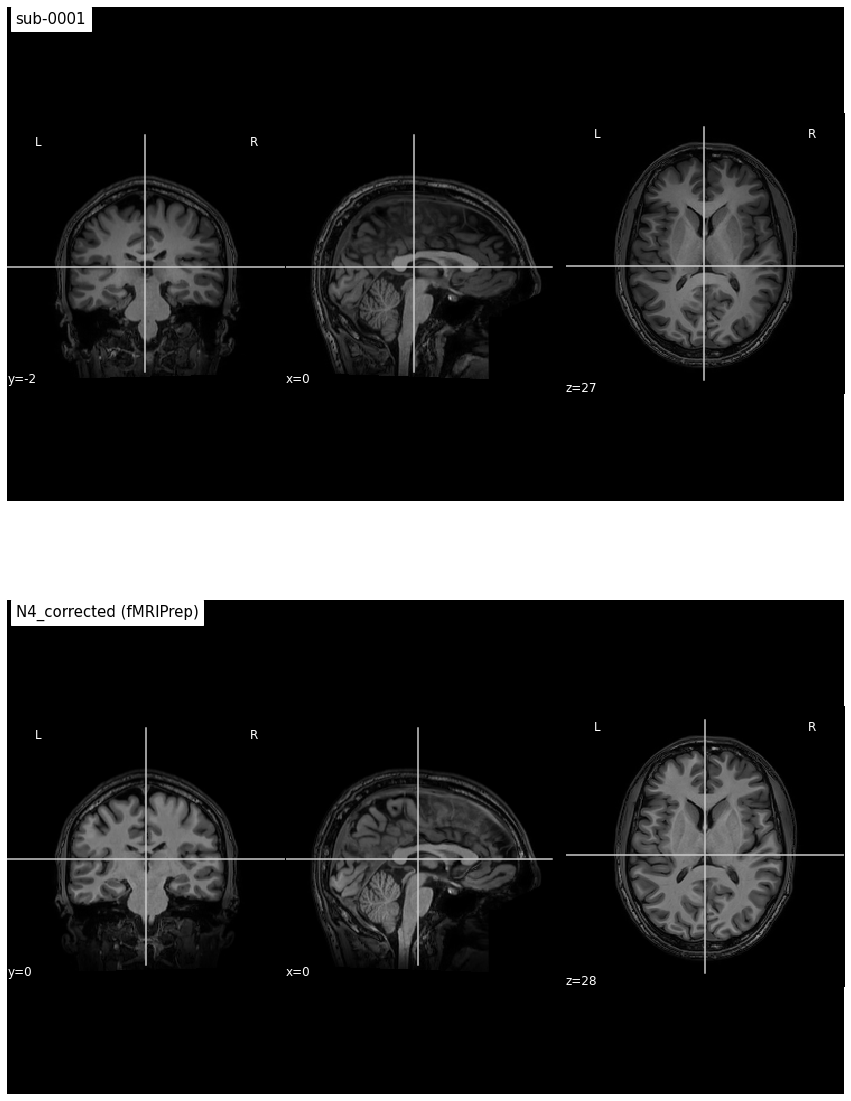

In [9]:
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# plot waw scan
vmax = 0.7 * nib.load(subject_T1).get_fdata().max()
plotting.plot_anat(subject_T1, title=subject_id, vmax=vmax, axes=ax1)

# Plot corrected image
vmax = 0.7 * nib.load(subject_T1_N4_corrected).get_fdata().max()
plotting.plot_anat(subject_T1_N4_corrected, title='N4_corrected (fMRIPrep)', vmax=vmax, axes=ax2)

In [ ]:
T1_orig = subject_dir + 'orig.mgz'
T1_corrected = subject_dir + 'nu.mgz'
T1_img_orig = nib.load(T1_orig)
T1_img_corrected = nib.load(T1_corrected)

# plot
cut_coords = (-85,-2,-5)
plotting.plot_anat(T1_orig, title="T1_orig", cut_coords=cut_coords, vmax=255)
plotting.plot_anat(T1_corrected, title="T1_corrected_img", cut_coords=cut_coords, vmax=255)